In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE, GATConv
import matplotlib.pyplot as plt

from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.utils import from_scipy_sparse_matrix, train_test_split_edges
from scipy.sparse import coo_matrix
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import add_self_loops
import csv
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, average_precision_score


import numpy as np

In [2]:
#pip install torch torchvision torchaudio
#pip install torch-geometric

In [3]:
ppi_df = pd.read_csv('9606.protein.links.v12.0.txt', delimiter= ' ')
rna_pca_df = pd.read_csv('Data/PPI_RNA_seq_10PCs.csv')
pe_pca_df = pd.read_csv('Data/PPI_protein_expression_10PCs.csv')
#ppi_df = pd.read_csv('filtered_PPI.csv')


In [4]:
ppi_df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000356607,173
1,9606.ENSP00000000233,9606.ENSP00000427567,154
2,9606.ENSP00000000233,9606.ENSP00000253413,151
3,9606.ENSP00000000233,9606.ENSP00000493357,471
4,9606.ENSP00000000233,9606.ENSP00000324127,201
...,...,...,...
13715399,9606.ENSP00000501317,9606.ENSP00000475489,195
13715400,9606.ENSP00000501317,9606.ENSP00000370447,158
13715401,9606.ENSP00000501317,9606.ENSP00000312272,226
13715402,9606.ENSP00000501317,9606.ENSP00000402092,169


In [5]:
rna_pca_df

,Protein,0,1,2,3,4,5,6,7,8,9
0,ENSP00000362111,-0.185353,-0.004533,-0.026467,0.023489,0.006372,0.010350,-0.017638,-0.018963,-0.090908,-0.125234
1,ENSP00000362122,-0.399261,-0.149002,-0.018040,-0.014601,0.003538,-0.009605,-0.007200,0.007645,-0.001761,0.003506
2,ENSP00000360638,-0.112412,0.007942,-0.021386,-0.001733,-0.014926,-0.003674,-0.005983,-0.013011,-0.020831,-0.011808
3,ENSP00000356746,-0.354238,-0.122491,-0.019377,-0.014322,0.005443,-0.006755,-0.006351,-0.003301,-0.002537,0.006392
4,ENSP00000286031,-0.394177,-0.147828,-0.018580,-0.015931,0.009358,-0.011189,-0.006518,0.001496,-0.007399,0.001637
...,...,...,...,...,...,...,...,...,...,...,...
19076,ENSP00000479586,-0.398100,-0.144587,-0.019146,-0.017504,0.014688,-0.014939,-0.003438,0.006843,-0.000927,0.012801
19077,ENSP00000492798,-0.409664,-0.154259,-0.017906,-0.015920,0.010782,-0.011493,-0.005786,0.008363,-0.000526,0.008326
19078,ENSP00000491046,-0.384420,-0.151079,-0.018764,-0.017182,0.009419,-0.011501,-0.008080,-0.012846,-0.020369,-0.009728
19079,ENSP00000491768,-0.412952,-0.153543,-0.017814,-0.016148,0.010864,-0.011281,-0.005109,0.007937,0.000992,0.010568


In [6]:
pe_pca_df

,Protein,0,1,2,3,4,5,6,7,8,9
0,ENSP00000475939,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
1,ENSP00000448165,-2.626324,1.219481,1.920547,-0.270693,-0.725231,0.880273,-0.456950,0.483047,0.868281,-1.455956
2,ENSP00000381148,0.717924,-2.768436,-0.418082,0.960015,0.635807,-0.778343,-0.028056,0.380815,-0.014020,-0.236685
3,ENSP00000326598,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
4,ENSP00000316605,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
...,...,...,...,...,...,...,...,...,...,...,...
10427,ENSP00000356231,2.504925,0.838916,1.854173,1.143358,-1.016118,-0.651189,0.523027,0.668288,-1.892422,0.579353
10428,ENSP00000376623,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
10429,ENSP00000496731,6.653803,0.376571,-0.548003,1.129220,-0.956416,0.208612,-0.717141,-0.812586,0.522268,0.654601
10430,ENSP00000457205,-4.150368,2.336989,-1.682337,2.139072,-1.398343,-0.840981,-0.036713,0.173603,-0.350784,-0.934075


In [7]:
def find_common_prefix(strings):
    if not strings:
        return ""
    prefix = strings[0]
    for string in strings[1:]:
        while not string.startswith(prefix):
            prefix = prefix[:-1]
            if not prefix:
                return ""
    return prefix


protein1_prefix = find_common_prefix(ppi_df['protein1'].tolist())
protein2_prefix = find_common_prefix(ppi_df['protein2'].tolist())

print("Common prefix in 'protein1':", protein1_prefix)
print("Common prefix in 'protein2':", protein2_prefix)

rna_seq_prefix = find_common_prefix(rna_pca_df['Protein'].tolist())

print("Common prefix in 'rna seq proteins':", rna_seq_prefix)

pe_prefix = find_common_prefix(pe_pca_df['Protein'].tolist())

print("Common prefix in 'protein expression proteins':", pe_prefix)


Common prefix in 'protein1': 9606.ENSP00000
Common prefix in 'protein2': 9606.ENSP00000
Common prefix in 'rna seq proteins': ENSP00000
Common prefix in 'protein expression proteins': ENSP00000


In [8]:
ppi_df['protein1'] = ppi_df['protein1'].str.replace(protein1_prefix, '', regex=False)
ppi_df['protein2'] = ppi_df['protein2'].str.replace(protein1_prefix, '', regex=False)
rna_pca_df['Protein'] = rna_pca_df['Protein'].str.replace(rna_seq_prefix, '', regex=False)
pe_pca_df['Protein'] = pe_pca_df['Protein'].str.replace(pe_prefix, '', regex=False)



In [9]:
combined_feature_df = rna_pca_df.merge(pe_pca_df, on = 'Protein')

In [10]:
combined_feature_df

,Protein,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y
0,362111,-0.185353,-0.004533,-0.026467,0.023489,0.006372,0.010350,-0.017638,-0.018963,-0.090908,...,-0.000602,-4.131053,1.092568,1.066263,4.105891,1.223702,-0.912633,0.505691,0.015278,1.311066
1,360638,-0.112412,0.007942,-0.021386,-0.001733,-0.014926,-0.003674,-0.005983,-0.013011,-0.020831,...,6.998952,0.499926,-1.005400,1.678182,-1.497004,-0.866389,0.292475,-0.861021,0.164524,0.154733
2,286031,-0.394177,-0.147828,-0.018580,-0.015931,0.009358,-0.011189,-0.006518,0.001496,-0.007399,...,3.201596,1.910247,-1.511976,1.664338,0.257424,-0.294570,0.570417,-1.171177,1.146728,0.227874
3,356399,0.091152,0.150518,-0.038688,0.000866,-0.126147,0.181274,-0.034913,-0.090164,0.212362,...,-6.655930,0.785581,-0.008520,0.305761,0.188402,0.218695,-0.097670,-0.213170,-0.037628,0.124348
4,002165,-0.211001,-0.023814,-0.018607,-0.001607,-0.032532,0.009361,-0.002882,0.020215,0.017727,...,-6.530891,0.683846,-0.062872,0.322792,-0.002302,0.240538,-0.097377,-0.307643,0.030064,0.042082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10388,357542,-0.405692,-0.157086,-0.017639,-0.016584,0.010726,-0.011171,-0.006142,0.001980,0.009834,...,-4.576977,-0.757462,-0.773499,0.128475,-1.686045,0.732733,0.250906,-0.219271,0.223310,0.228589
10389,326598,-0.364407,-0.155280,-0.017782,0.009217,0.011083,-0.012945,-0.013386,-0.014113,-0.072935,...,-6.780969,0.887315,0.045832,0.288730,0.379106,0.196851,-0.097963,-0.118697,-0.105319,0.206615
10390,383067,-0.394685,-0.145409,-0.018640,-0.014483,0.005992,-0.009644,-0.006573,0.004504,-0.000570,...,-0.968921,-2.445984,-0.523138,0.711910,0.569157,2.539323,-2.035485,0.306880,-0.259937,0.999907
10391,444433,-0.388056,-0.138258,-0.018770,-0.016226,0.009223,-0.011057,-0.006242,0.011084,0.008256,...,0.326333,-3.057778,0.395192,-0.527841,0.112054,-1.451205,0.037491,0.865294,0.565607,-0.484290


## Model

In [33]:

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)  # Extra message passing
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))  # Additional message passing
        x = self.dropout(x)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        return mu, logstd
    

def train(model, data, optimizer, patience=15, delta=0.2, checkpoint_path="best_model.pth"):
    best_auc = float('-inf')
    counter = 0
    num_epochs = 200
    
    auc_values = []
    ap_values = []
    precision_values = []
    recall_values = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        z = model.encode(data.x, data.train_pos_edge_index)
        loss = model.recon_loss(z, data.train_pos_edge_index)
        loss += (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        optimizer.step()

        # Compute validation AUC, AP, Precision, Recall
        auc_score, ap_score, precision, recall = test(model, data)
        auc_values.append(auc_score)
        ap_values.append(ap_score)
        precision_values.append(precision)
        recall_values.append(recall)

        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss:.4f}, AUC: {auc_score:.4f}, AP: {ap_score:.4f}")

        # Early stopping logic
        if auc_score > best_auc + delta:
            best_auc = auc_score
            counter = 0
            torch.save(model.state_dict(), checkpoint_path)  # Save best model
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}. Best AUC: {best_auc:.4f}")
                break

    # Load the best model
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Best model restored with AUC: {best_auc:.4f}")

    # Store metrics in a dictionary
    metrics_dict = {
        "AUC": auc_values,
        "AP": ap_values,
        "Precision": precision_values,
        "Recall": recall_values
    }
    
    return metrics_dict


def test(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)

        # Compute predicted scores
        pos_edge_scores = model.decoder(z, data.test_pos_edge_index).sigmoid().cpu().numpy()
        neg_edge_scores = model.decoder(z, data.test_neg_edge_index).sigmoid().cpu().numpy()

        # Ground truth labels (1 for positive edges, 0 for negative edges)
        y_true = np.concatenate([np.ones(pos_edge_scores.shape[0]), np.zeros(neg_edge_scores.shape[0])])
        y_scores = np.concatenate([pos_edge_scores, neg_edge_scores])

        # Compute AUC and AP
        auc_score = roc_auc_score(y_true, y_scores)
        ap_score = average_precision_score(y_true, y_scores)

        # Compute Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_true, y_scores)

    return auc_score, ap_score, precision, recall

## Combined features

In [34]:
valid_nodes = set(combined_feature_df['Protein'])
ppi_df_filtered = ppi_df[ppi_df['protein1'].isin(valid_nodes) & ppi_df['protein2'].isin(valid_nodes)]

filtered_nodes = pd.concat([ppi_df_filtered['protein1'], ppi_df_filtered['protein2']]).unique()
node_to_idx = {node: i for i, node in enumerate(filtered_nodes)}

ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)

adj_matrix = coo_matrix(
    (ppi_df_filtered['combined_score'], (ppi_df_filtered['protein1_idx'], ppi_df_filtered['protein2_idx'])),
    shape=(len(filtered_nodes), len(filtered_nodes))
)

combined_feature_df['node_idx'] = combined_feature_df['Protein'].map(node_to_idx)
feature_df_filtered = combined_feature_df.dropna(subset=['node_idx']).sort_values(by='node_idx')
feature_matrix = feature_df_filtered.iloc[:, 1:-1].values  # exclude 'Protein' and 'node_idx'
feature_matrix = StandardScaler().fit_transform(feature_matrix)

assert adj_matrix.shape[0] == feature_matrix.shape[0]


edge_index, edge_attr = from_scipy_sparse_matrix(adj_matrix)
data = Data(edge_index=edge_index, edge_attr=edge_attr, x=torch.tensor(feature_matrix, dtype=torch.float))

data = train_test_split_edges(data, val_ratio=0.2, test_ratio=0.2)

data.train_pos_edge_index, _ = add_self_loops(data.train_pos_edge_index)


C:\Users\siddu\AppData\Local\Temp\ipykernel_33612\1824750309.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
C:\Users\siddu\AppData\Local\Temp\ipykernel_33612\1824750309.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)
c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_

In [35]:
in_channels = data.x.shape[1]  # Number of features
out_channels = 32
model = VGAE(GCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

metrics_dict = train(model, data, optimizer)


Epoch 1/200 - Loss: 4.7469, AUC: 0.7578, AP: 0.7693
Epoch 2/200 - Loss: 4.5044, AUC: 0.7558, AP: 0.7679
Epoch 3/200 - Loss: 4.3199, AUC: 0.7575, AP: 0.7694
Epoch 4/200 - Loss: 4.0665, AUC: 0.7591, AP: 0.7707
Epoch 5/200 - Loss: 3.8038, AUC: 0.7602, AP: 0.7715
Epoch 6/200 - Loss: 3.5146, AUC: 0.7608, AP: 0.7719
Epoch 7/200 - Loss: 3.2340, AUC: 0.7613, AP: 0.7723
Epoch 8/200 - Loss: 2.9687, AUC: 0.7617, AP: 0.7727
Epoch 9/200 - Loss: 2.7034, AUC: 0.7621, AP: 0.7730
Epoch 10/200 - Loss: 2.4556, AUC: 0.7626, AP: 0.7735
Epoch 11/200 - Loss: 2.2257, AUC: 0.7634, AP: 0.7742
Epoch 12/200 - Loss: 1.9951, AUC: 0.7649, AP: 0.7755
Epoch 13/200 - Loss: 1.8084, AUC: 0.7670, AP: 0.7774
Epoch 14/200 - Loss: 1.6647, AUC: 0.7698, AP: 0.7800
Epoch 15/200 - Loss: 1.5585, AUC: 0.7730, AP: 0.7831
Epoch 16/200 - Loss: 1.4857, AUC: 0.7756, AP: 0.7859
Early stopping triggered at epoch 16. Best AUC: 0.7578
Best model restored with AUC: 0.7578


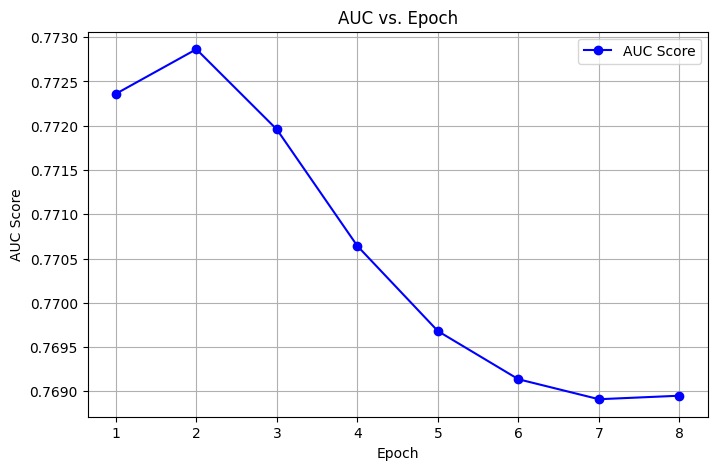

In [14]:
# Plot AUC over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AUC"]) + 1), metrics_dict["AUC"], marker='o', linestyle='-', color='b', label="AUC Score")
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()


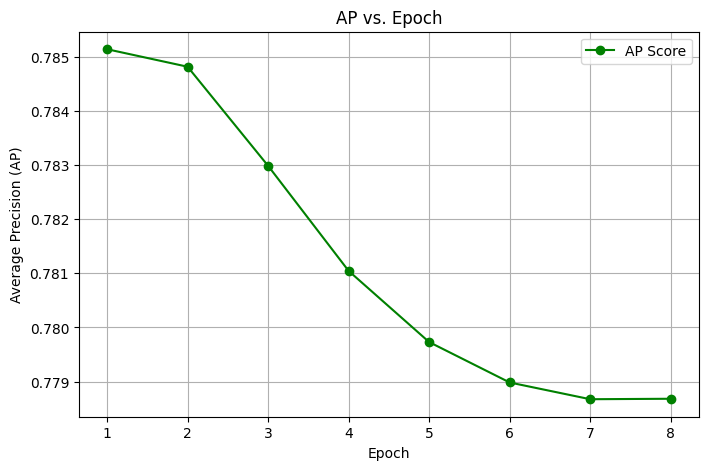

In [15]:
# Plot AP over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AP"]) + 1), metrics_dict["AP"], marker='o', linestyle='-', color='g', label="AP Score")
plt.xlabel("Epoch")
plt.ylabel("Average Precision (AP)")
plt.title("AP vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()


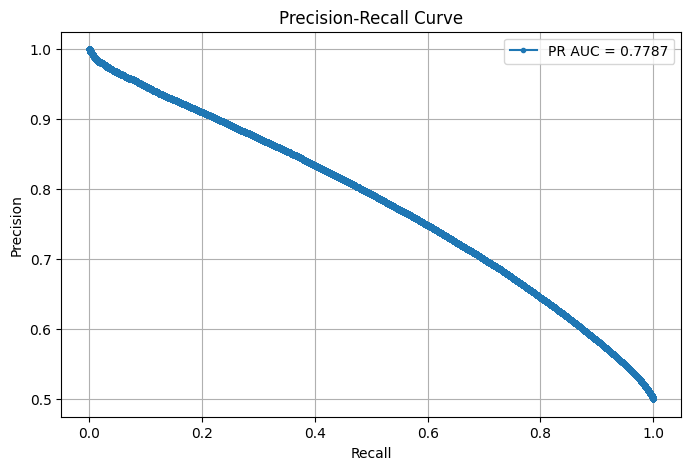

In [16]:
# Plot Precision-Recall Curve
precision = metrics_dict["Precision"][-1]  # Last epoch's precision
recall = metrics_dict["Recall"][-1]  # Last epoch's recall
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
with open("training_metrics_combined.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "AUC", "AP"])
    for i in range(len(metrics_dict["AUC"])):
        writer.writerow([i + 1, metrics_dict["AUC"][i], metrics_dict["AP"][i]])

## RNA Features

In [18]:
valid_nodes = set(rna_pca_df['Protein'])
ppi_df_filtered = ppi_df[ppi_df['protein1'].isin(valid_nodes) & ppi_df['protein2'].isin(valid_nodes)]

filtered_nodes = pd.concat([ppi_df_filtered['protein1'], ppi_df_filtered['protein2']]).unique()
node_to_idx = {node: i for i, node in enumerate(filtered_nodes)}

ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)

adj_matrix = coo_matrix(
    (ppi_df_filtered['combined_score'], (ppi_df_filtered['protein1_idx'], ppi_df_filtered['protein2_idx'])),
    shape=(len(filtered_nodes), len(filtered_nodes))
)

rna_pca_df['node_idx'] = rna_pca_df['Protein'].map(node_to_idx)
feature_df_filtered = rna_pca_df.dropna(subset=['node_idx']).sort_values(by='node_idx')
feature_matrix = feature_df_filtered.iloc[:, 1:-1].values  # exclude 'Protein' and 'node_idx'
feature_matrix = StandardScaler().fit_transform(feature_matrix)

assert adj_matrix.shape[0] == feature_matrix.shape[0]


edge_index, edge_attr = from_scipy_sparse_matrix(adj_matrix)
data = Data(edge_index=edge_index, edge_attr=edge_attr, x=torch.tensor(feature_matrix, dtype=torch.float))

data = train_test_split_edges(data, val_ratio=0.2, test_ratio=0.2)

data.train_pos_edge_index, _ = add_self_loops(data.train_pos_edge_index)

C:\Users\siddu\AppData\Local\Temp\ipykernel_33612\3794215482.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
C:\Users\siddu\AppData\Local\Temp\ipykernel_33612\3794215482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)
c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_

In [19]:
in_channels = data.x.shape[1]  # Number of features
out_channels = 32
model = VGAE(GCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

metrics_dict = train(model, data, optimizer)

Epoch 1/200 - Loss: 4.7919, AUC: 0.7709, AP: 0.7823
Epoch 2/200 - Loss: 4.6222, AUC: 0.7716, AP: 0.7817
Epoch 3/200 - Loss: 4.4717, AUC: 0.7726, AP: 0.7821
Epoch 4/200 - Loss: 4.3191, AUC: 0.7737, AP: 0.7827
Epoch 5/200 - Loss: 4.1183, AUC: 0.7748, AP: 0.7833
Epoch 6/200 - Loss: 3.9041, AUC: 0.7756, AP: 0.7837
Epoch 7/200 - Loss: 3.6603, AUC: 0.7762, AP: 0.7841
Epoch 8/200 - Loss: 3.4136, AUC: 0.7767, AP: 0.7844
Early stopping triggered at epoch 8. Best AUC: 0.7709
Best model restored with AUC: 0.7709


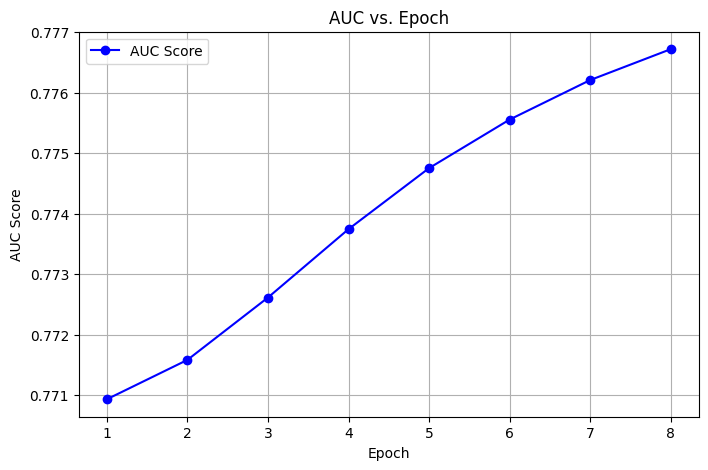

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AUC"]) + 1), metrics_dict["AUC"], marker='o', linestyle='-', color='b', label="AUC Score")
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()


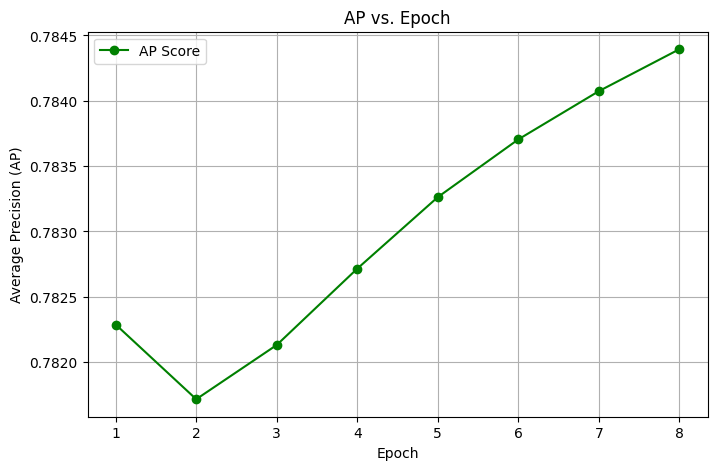

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AP"]) + 1), metrics_dict["AP"], marker='o', linestyle='-', color='g', label="AP Score")
plt.xlabel("Epoch")
plt.ylabel("Average Precision (AP)")
plt.title("AP vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

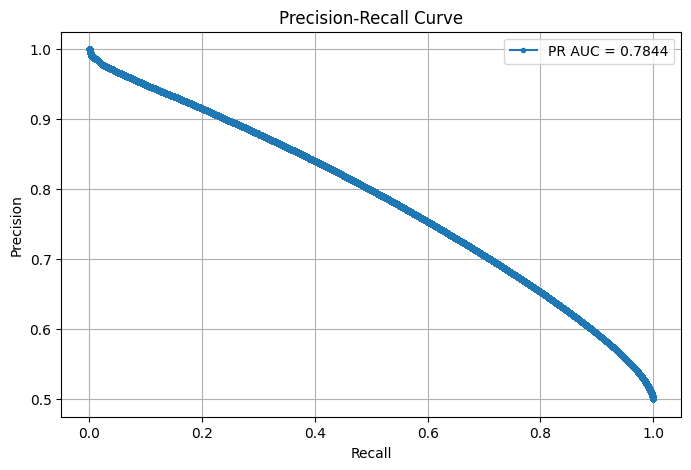

In [22]:
precision = metrics_dict["Precision"][-1]  # Last epoch's precision
recall = metrics_dict["Recall"][-1]  # Last epoch's recall
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
with open("training_metrics_rna.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "AUC", "AP"])
    for i in range(len(metrics_dict["AUC"])):
        writer.writerow([i + 1, metrics_dict["AUC"][i], metrics_dict["AP"][i]])

## Protein Expression Features

In [24]:
valid_nodes = set(pe_pca_df['Protein'])
ppi_df_filtered = ppi_df[ppi_df['protein1'].isin(valid_nodes) & ppi_df['protein2'].isin(valid_nodes)]

filtered_nodes = pd.concat([ppi_df_filtered['protein1'], ppi_df_filtered['protein2']]).unique()
node_to_idx = {node: i for i, node in enumerate(filtered_nodes)}

ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)

adj_matrix = coo_matrix(
    (ppi_df_filtered['combined_score'], (ppi_df_filtered['protein1_idx'], ppi_df_filtered['protein2_idx'])),
    shape=(len(filtered_nodes), len(filtered_nodes))
)

pe_pca_df['node_idx'] = pe_pca_df['Protein'].map(node_to_idx)
feature_df_filtered = pe_pca_df.dropna(subset=['node_idx']).sort_values(by='node_idx')
feature_matrix = feature_df_filtered.iloc[:, 1:-1].values  # exclude 'Protein' and 'node_idx'
feature_matrix = StandardScaler().fit_transform(feature_matrix)

assert adj_matrix.shape[0] == feature_matrix.shape[0]


edge_index, edge_attr = from_scipy_sparse_matrix(adj_matrix)
data = Data(edge_index=edge_index, edge_attr=edge_attr, x=torch.tensor(feature_matrix, dtype=torch.float))

data = train_test_split_edges(data, val_ratio=0.2, test_ratio=0.2)

data.train_pos_edge_index, _ = add_self_loops(data.train_pos_edge_index)

C:\Users\siddu\AppData\Local\Temp\ipykernel_33612\2604877062.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein1_idx'] = ppi_df_filtered['protein1'].map(node_to_idx)
C:\Users\siddu\AppData\Local\Temp\ipykernel_33612\2604877062.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppi_df_filtered['protein2_idx'] = ppi_df_filtered['protein2'].map(node_to_idx)
c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_

In [25]:
in_channels = data.x.shape[1]  # Number of features
out_channels = 32
model = VGAE(GCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

metrics_dict = train(model, data, optimizer)

Epoch 1/200 - Loss: 4.7942, AUC: 0.7726, AP: 0.7844
Epoch 2/200 - Loss: 4.5782, AUC: 0.7714, AP: 0.7829
Epoch 3/200 - Loss: 4.3648, AUC: 0.7707, AP: 0.7816
Epoch 4/200 - Loss: 4.1197, AUC: 0.7702, AP: 0.7807
Epoch 5/200 - Loss: 3.8517, AUC: 0.7701, AP: 0.7801
Epoch 6/200 - Loss: 3.5711, AUC: 0.7700, AP: 0.7798
Epoch 7/200 - Loss: 3.2633, AUC: 0.7702, AP: 0.7799
Epoch 8/200 - Loss: 2.9921, AUC: 0.7705, AP: 0.7801
Early stopping triggered at epoch 8. Best AUC: 0.7726
Best model restored with AUC: 0.7726


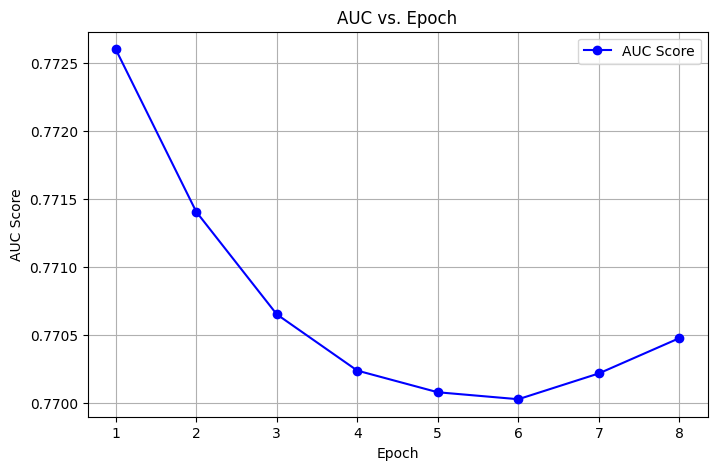

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AUC"]) + 1), metrics_dict["AUC"], marker='o', linestyle='-', color='b', label="AUC Score")
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

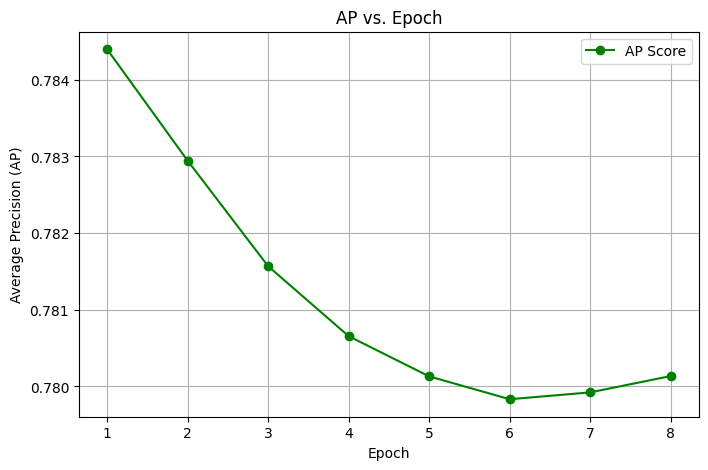

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(metrics_dict["AP"]) + 1), metrics_dict["AP"], marker='o', linestyle='-', color='g', label="AP Score")
plt.xlabel("Epoch")
plt.ylabel("Average Precision (AP)")
plt.title("AP vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

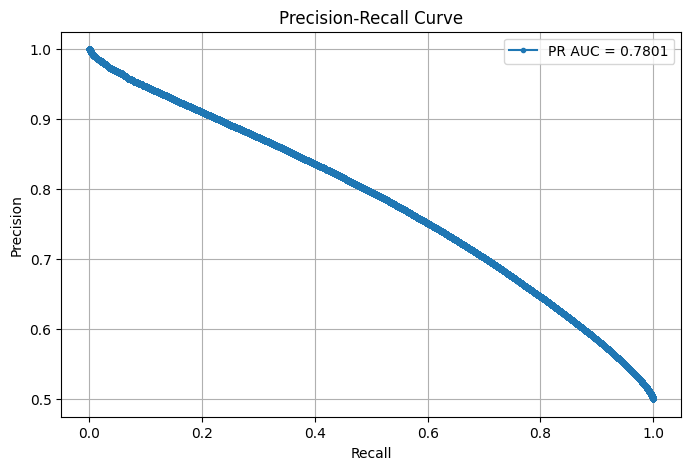

In [28]:
precision = metrics_dict["Precision"][-1]  # Last epoch's precision
recall = metrics_dict["Recall"][-1]  # Last epoch's recall
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
with open("training_metrics_pe.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "AUC", "AP"])
    for i in range(len(metrics_dict["AUC"])):
        writer.writerow([i + 1, metrics_dict["AUC"][i], metrics_dict["AP"][i]])